<a href="https://colab.research.google.com/github/AmbiTyga/Bio-VI-BERT/blob/main/PHYLUM_Image_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git -q
!pip install pytorch-lightning -q
!git clone https://github.com/hila-chefer/Transformer-Explainability.git
!pip install einops -q

In [2]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Train.7z
!7z x /content/Train.7z

--2021-04-28 03:07:26--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Train.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13524763 (13M) [application/octet-stream]
Saving to: ‘Train.7z’

Train.7z            100%[===================>]  12.90M  --.-KB/s    in 0.07s   

2021-04-28 03:07:26 (174 MB/s) - ‘Train.7z’ saved [13524763/13524763]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 13524763 bytes (13 MiB)

Extracting archive: /content/Train.7z
--
Path = /content/Train.7z
Typ

In [3]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Val.7z
!7z x /content/Val.7z

--2021-04-28 03:07:27--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Val.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4593856 (4.4M) [application/octet-stream]
Saving to: ‘Val.7z’

Val.7z              100%[===================>]   4.38M  --.-KB/s    in 0.04s   

2021-04-28 03:07:28 (112 MB/s) - ‘Val.7z’ saved [4593856/4593856]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 4593856 bytes (4487 KiB)

Extracting archive: /content/Val.7z
--
Path = /content/Val.7z
Type = 7z
Phys

In [4]:
import timm
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from pytorch_lightning.callbacks import ModelCheckpoint

from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

## Cleaning and getting a final data

In [ ]:
## Getting images(file path) from the directories 

imgs = []
for path, subdirs, files in os.walk('./Dataset'):
    for name in files:
        imgs.append(os.path.join(path, name))
imgs = [x for x in imgs if '.csv' not in x]

In [ ]:
data = pd.read_excel("/content/Dataset/all_meta_data.xlsx")
data.head()

In [ ]:
data = pd.read_csv('/content/parasites.csv')

In [ ]:
data['species'].value_counts()

Plasmodium malariae          185
Cyclospora cayetanensis      185
Entamoeba histolytica        180
Ascaris lumbricoides         180
Plasmodium vivax             180
Plasmodium falciparum        180
Giardia duodenalis           180
Plasmodium ovale             170
Strongyloides stercoralis    110
Dibothriocephalus latus      105
Trichuris Trichuria           95
Enterobius vermicularis       90
Toxocara canis                85
Ancyclostoma sp               85
Sarcocystis sp                80
Cryptosporidium sp            80
Plasmodium knowlesi           75
Hymenolepis nana              70
Toxoplasma gondii             65
Trichinella sp                65
Name: species, dtype: int64

In [ ]:
# data = [x for _,x in data.groupby('species') if len(x)>15]

# data = pd.concat(data,ignore_index=True)

label_encoders = dict()
labels = ["phylum","class","species","form","sample"]
for x in labels:
  le = LabelEncoder()
  data[f'{x}_label'] = le.fit_transform(data[x])
  label_encoders[x] = le

In [ ]:
train, val = train_test_split(
    data, test_size=0.25, random_state=2021,stratify = data['species'])

In [ ]:
train.to_csv('/content/train.csv',index = False)

val.to_csv('/content/val.csv',index = False)

# Labeling

In [5]:
train = pd.read_csv("/content/train/train.csv")

val = pd.read_csv("/content/val/val.csv")

In [6]:
le = LabelEncoder()
train['phylum_label'] = le.fit_transform(train['phylum'])

val['phylum_label'] = le.transform(val['phylum'])

# Dataset Function

In [7]:
from PIL import Image
from glob import glob
images = [x for x in glob('./val/*/*') if 'val.csv' not in x]
for i in images:
  Image.open(i).convert('RGB').save(i)

In [8]:
class SpeciesDataset(Dataset):
  def __init__(self,csv_file,transform):
    super().__init__()
    csv = csv_file[['phylum_label','img_path']]
    self.labels = csv['phylum_label'].values

    self.images = csv['img_path'].values
    self.transform = transform

    # self.LE = LabelEncoder()
    # self.labels = self.LE.fit_transform(labels)    

  def __len__(self):
    # return size of dataset
    return len(self.images)

  def __getitem__(self, index):
    img = Image.open(self.images[index])
    img = self.transform(img)

    label = self.labels[index]

    return {'images':img, 'labels':label}

In [9]:
train_transformer = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

val_transformer = transforms.Compose([
        transforms.Resize((224,224)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

In [ ]:
train['phylum'].value_counts()

Apicomplexa          710
Nematoda             380
Platyhelminthes      160
Amoebozoa            100
Sarcomastigophora    100
Name: phylum, dtype: int64

In [10]:
class_counts = train['phylum_label'].value_counts().to_dict()
train_weights = torch.tensor([1/class_counts[label] for label in train['phylum_label'].values])

train_dataset = SpeciesDataset(train,transform=train_transformer)

class_counts = val['phylum_label'].value_counts().to_dict()
val_weights = torch.tensor([1/class_counts[label] for label in val['phylum_label'].values])

val_dataset = SpeciesDataset(val,transform=val_transformer)

# VIT Base Imagenet 21k

In [11]:
class ViT(pl.LightningModule):
  def __init__(
      self,
      num_classes_classifier,
      train_weights,
      val_weights,
      train_dataset,
      val_dataset):
    super().__init__()

    self.tw = train_weights
    self.vw = val_weights

    self.train_dataset = train_dataset
    self.val_dataset = val_dataset


    self.loss_fn = nn.CrossEntropyLoss()

    self.img_transformer = timm.models.vision_transformer.vit_base_patch16_224_in21k(pretrained=True,num_classes = 0)
    self.q = nn.Linear(768,512)
    self.k = nn.Linear(768,512)
    self.v = nn.Linear(768,512)
    # self.drop = nn.Dropout(0.4)
    self.mha = nn.MultiheadAttention(512,8)

    self.act_layer = nn.GELU()

    self.classifier = nn.Sequential(nn.BatchNorm1d(512),
                                    nn.Linear(512,num_classes_classifier))

  def forward(self,img):
    repr = torch.relu(self.img_transformer(img)).unsqueeze(dim=0)
    q,k,v = self.q(repr),self.k(repr),self.v(repr)
    repr,_ = self.mha(q,k,v) 
    # repr = self.drop(repr)
    repr = self.act_layer(repr).squeeze(dim=0)
    output = self.classifier(repr)
    return output  

  def train_dataloader(self):
    return torch.utils.data.DataLoader(
        self.train_dataset,
        batch_size=64,
        sampler=torch.utils.data.WeightedRandomSampler(self.tw,num_samples=3550),
        num_workers = os.cpu_count()
        )

  def val_dataloader(self):
    return torch.utils.data.DataLoader(
        self.val_dataset,
        batch_size = 51,
        sampler = torch.utils.data.WeightedRandomSampler(self.vw,num_samples=1225),
        num_workers = os.cpu_count()
        )
    
  def training_step(self, batch ,batch_idx):
    images = batch["images"]
    labels = batch['labels']
    outputs = self(img=images)
    loss = self.loss_fn(outputs,labels)
    acc = (outputs.argmax(dim=1).view(labels.size()).data == labels.data).sum()/labels.size(0)
    
    # self.log("loss",loss,prog_bar=True)
    self.log("accuracy",acc,prog_bar=True)
    return {"loss": loss,'accuracy':acc}

  def validation_step(self, batch ,batch_idx):
    images = batch["images"]
    labels = batch['labels']
    outputs = self(img=images)
    loss = self.loss_fn(outputs,labels)
    acc = (outputs.argmax(dim=1).view(labels.size()).data == labels.data).sum()/labels.size(0)
    
    # self.log("val_loss",loss,prog_bar=True)
    # self.log("val_accuracy",acc,prog_bar=True)
    return {"val_loss": loss.item(),'val_accuracy':acc.item()}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.tensor(
            [output["val_loss"] 
            for output in outputs]
            ).mean()
    avg_acc = torch.tensor(
            [output["val_accuracy"] 
            for output in outputs]
            ).mean()
    
    self.log("val_loss",avg_loss,prog_bar=True)
    self.log("val_accuracy",avg_acc,prog_bar=True)

  def configure_optimizers(self):
    optimizer = [torch.optim.AdamW(
            self.parameters(), 
            lr=1e-4
        )]
    # schedulers = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #         optimizer[0],
    #         mode='max'
    #     )
    return optimizer


In [12]:
model = ViT(
    num_classes_classifier=5,
    train_weights=train_weights,
    val_weights=val_weights,
    train_dataset=train_dataset,
    val_dataset=val_dataset
    )

Removing representation layer for fine-tuning.
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_patch16_224_in21k-e5005f0a.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_patch16_224_in21k-e5005f0a.pth


In [ ]:
model

In [13]:
early_stop_callback = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.00,
   patience=20,
   verbose=False,
   mode='max'
)

model_ckpt = ModelCheckpoint(
    monitor='val_accuracy',
    dirpath='./',
    filename='ViT-{val_accuracy:.2f}',
    mode='max')

trainer = pl.Trainer(gpus=1,max_epochs=120,accumulate_grad_batches=2,num_sanity_val_steps=2,callbacks=[early_stop_callback,model_ckpt])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params
-------------------------------------------------------
0 | loss_fn         | CrossEntropyLoss   | 0     
1 | img_transformer | VisionTransformer  | 85.8 M
2 | q               | Linear             | 393 K 
3 | k               | Linear             | 393 K 
4 | v               | Linear             | 393 K 
5 | mha             | MultiheadAttention | 1.1 M 
6 | act_layer       | GELU               | 0     
7 | classifier      | Sequential         | 3.6 K 
-------------------------------------------------------
88.0 M    Trainable params
0         Non-trainable params
88.0 M    Total params
352.136   Total estimated model params size (MB)


1

In [ ]:
#@title EarlyStopping
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [ ]:
#@title Traditional Training
device = torch.device('cuda')
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = 1e-4)
loss_fn = nn.CrossEntropyLoss().to(device)
patience = 10
best_acc = -np.inf

model.to(device)

train_losses = []
train_accs = []
val_losses = []
val_accs = []
for epoch in range(100):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  steps = 0
  for idx, batch in enumerate(train_loader):
    image, target = batch
    image = image.to(device)
    target = target.flatten().to(device)

    optim.zero_grad()

    prediction = model(image)
    # print(prediction,target)
    loss = loss_fn(prediction, target)

    num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
    acc = 100.0 * (num_corrects/target.size(0))
    loss.backward()
    optim.step()
    steps += 1
    
    # if steps % 6 == 0:
    #     print (f'\t Train - Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
    
    train_epoch_loss += loss.item()
    train_epoch_acc += acc.item()

  val_epoch_loss = 0
  val_epoch_acc = 0
  model.eval()
  val_steps = 0
  with torch.no_grad():
    for idx, batch in enumerate(val_loader):
      image, target = batch
      image = image.to(device)
      target = target.flatten().to(device)

      prediction = model(image)
      loss = loss_fn(prediction, target)
      
      num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
      acc = 100.0 * (num_corrects/target.size(0))

      val_epoch_loss += loss.item()
      val_epoch_acc += acc.item()
      val_steps +=1

  
  val_epoch_loss /=val_steps
  val_epoch_acc /=val_steps
  
  print(f"Epoch: {epoch+1:02}, Train Loss: {train_epoch_loss/steps:.3f}, Train Acc: {train_epoch_acc/steps:.2f}%, Val. Loss: {val_epoch_loss:.3f}, Val. Acc: {val_epoch_acc:.2f}% \n{90*'='}")
  
  if val_epoch_acc > best_acc:
    
    print(f'\r\t{best_acc:.3f} --> {val_epoch_acc:.3f}  Updating')
    best_acc = val_epoch_acc
    torch.save(model.state_dict(),'vit-base.bin')
    patience = 10
    train_losses.append(train_epoch_loss/steps)
    train_accs.append(train_epoch_acc/steps)

    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
  if val_epoch_acc < best_acc:
    patience -=1
    print(f'\r\t Patience -> {patience}')
  if patience<=0:
    print(f'\r\tPatience complete! Best Acc is {best_acc:.3f}')
    break
  

Epoch: 01, Train Loss: 0.271, Train Acc: 91.46%, Val. Loss: 0.525, Val. Acc: 81.33% 
	-inf --> 81.333  Updating
Epoch: 02, Train Loss: 0.013, Train Acc: 99.80%, Val. Loss: 0.511, Val. Acc: 81.73% 
	81.333 --> 81.725  Updating
Epoch: 03, Train Loss: 0.003, Train Acc: 100.00%, Val. Loss: 0.509, Val. Acc: 82.59% 
	81.725 --> 82.588  Updating
Epoch: 04, Train Loss: 0.002, Train Acc: 100.00%, Val. Loss: 0.586, Val. Acc: 82.43% 
	 Patience -> 9
Epoch: 05, Train Loss: 0.001, Train Acc: 100.00%, Val. Loss: 0.612, Val. Acc: 81.73% 
	 Patience -> 8
Epoch: 06, Train Loss: 0.001, Train Acc: 100.00%, Val. Loss: 0.565, Val. Acc: 83.84% 
	82.588 --> 83.843  Updating
Epoch: 07, Train Loss: 0.001, Train Acc: 100.00%, Val. Loss: 0.749, Val. Acc: 79.37% 
	 Patience -> 9
Epoch: 08, Train Loss: 0.001, Train Acc: 100.00%, Val. Loss: 0.703, Val. Acc: 80.78% 
	 Patience -> 8
Epoch: 09, Train Loss: 0.000, Train Acc: 100.00%, Val. Loss: 0.645, Val. Acc: 81.96% 
	 Patience -> 7
Epoch: 10, Train Loss: 0.000, Trai

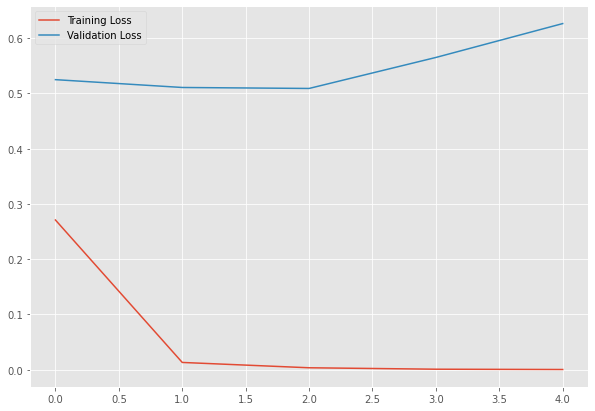

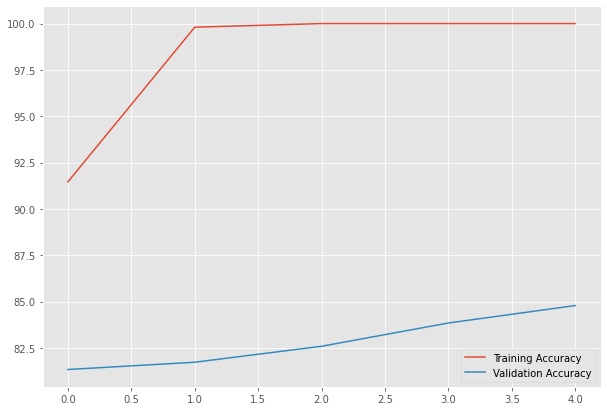

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10,7))
plt.plot(train_losses,label='Training Loss')
plt.plot(val_losses,label='Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(train_accs,label='Training Accuracy')
plt.plot(val_accs,label='Validation Accuracy')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

val_dataset = SpeciesDataset(val,transform=val_transformer)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=51)

model = ViT.load_from_checkpoint("/content/ViT-val_accuracy=0.84.ckpt",num_classes_classifier=5,
    train_weights=None,
    val_weights=None,
    train_dataset=None,
    val_dataset=None
    )
model.cuda()
model.eval()
preds = np.array([])
label = np.array([])
with torch.no_grad():
  for batch in val_loader:
    images = batch["images"].cuda()
    labels = batch['labels']
    label = np.append(label,labels)
    prediction = model(images)
    preds = np.append(preds,prediction.argmax(dim=1).view(labels.size()).cpu().numpy())


print(classification_report(label,preds,target_names=le.classes_))

                   precision    recall  f1-score   support

        Amoebozoa       0.97      0.94      0.96        35
      Apicomplexa       0.97      1.00      0.98       245
         Nematoda       0.80      0.95      0.87       120
  Platyhelminthes       0.74      0.40      0.52        50
Sarcomastigophora       0.93      0.80      0.86        35

         accuracy                           0.91       485
        macro avg       0.88      0.82      0.84       485
     weighted avg       0.90      0.91      0.90       485



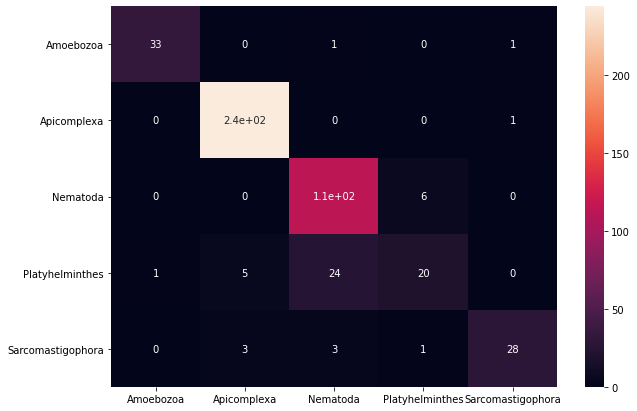

In [27]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(label,preds)
df_cm = pd.DataFrame(confusion, index = le.classes_,
                  columns = le.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [33]:
%cd Transformer-Explainability

/content/Transformer-Explainability


# LRP

In [44]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# initialize ViT pretrained
# model = vit_LRP(pretrained=True).cuda()
model.eval()
attribution_generator = LRP(model)

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis


In [37]:
le.classes_

array(['Amoebozoa', 'Apicomplexa', 'Nematoda', 'Platyhelminthes',
       'Sarcomastigophora'], dtype=object)

In [38]:
le.transform(le.classes_)

array([0, 1, 2, 3, 4])

In [40]:
train.sample()

,phylum,class,genus,species,form,sample,img_path,phylum_label
976,Platyhelminthes,Cestoda,Hymenolepis,Hymenolepis spp,egg,feces,./train/Hymenolepis spp/H_nana_HE1_1_200.jpg,3


In [ ]:
image = Image.open('/content/train/Hymenolepis spp/H_nana_HE1_1_200.jpg') ##
dog_cat_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())


# cat - the predicted class
cat = generate_visualization(dog_cat_image)

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(dog_cat_image, class_index=3)


axs[1].imshow(cat);
axs[1].axis('off');
axs[2].imshow(dog);
axs[2].axis('off');